# Packet-Scheduling with Reinforcement Learning

**Objective**  
Build and compare:
1. A custom Gym env for three-class packet scheduling (video/voice/best-effort).  
2. Three fixed scheduling policies (FIFO, EDF, Sequential Priority).  
3. A tabular Q-learning agent that meets hard-deadline constraints on P1/P2 while minimizing P3 delay for scenario 1.
4. ...


**Notebook roadmap**  
1. [Problem formulation (MDP)](#formulation)  
2. [Environment implementation](#env)  
3. [Baseline policies](#baselines)  
4. [Reinforcement-learning agent](#rl-agent)  
5. [Results & comparison](#results)  
6. [Conclusions & next steps](#conclusion)  

## 1. MDP Formulation

- **State**  
  - \(q_i\): queue lengths for Video (P1), Voice (P2), Best-Effort (P3).  
  - Slack times \(\Delta_1, \Delta_2\) for P1/P2 head-of-line packets.  
  - Current queue pointer \(c\).  

- **Actions**  
  - Low-spec router: serve current queue, switch queue
  - High-spec router: switch-and-serve  

- **Reward**  
  - ...

- **Performance metrics**  
  - Deadline violations (P1,P2)  
  - Mean delay for P3  

### Imports

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from gymnasium.utils import seeding
from IPython.display import clear_output
import time
from collections import defaultdict, deque
import random

## 2. PacketSchedulerEnv

We implement a Gym Env with:
- Poisson arrivals (λ₁=0.3, λ₂=0.25, λ₃=0.4)
- Three FIFO queues with per-queue QoS limits [6,4,None]
- Two scenarios:  
  1. Low-spec router (three actions available -- switch queue, serve queue, and do nothing -- both with cost of one timeslot)  
  2. High-spec router (two actiona available -- switch queue and serve, serve current queue, and do nothing -- both of which have a cost of one timeslot) *still need to implement*

In [ ]:
class PacketSchedulerEnv(Env):
    """
    OpenAI Gymnasium environment simulating packet scheduling across three queues:
    """

    def __init__(self, scenario=1, arrival_probs = [0.3, 0.25, 0.4], seed = None) :
        """
        Constructor
        takes the scenario 1 or 2 as arguments
        """
        super().__init__()
        self.num_queues = 3
        self.max_queue_size = 50
        self.scenario = scenario
        self.current_queue = 0  # Only used in scenario 2
        self.time = 0
        self.empty_serving = 0

        self.qos_limits = [6, 4, None]  # Video, Voice, Best-Effort
        self.arrival_probs = arrival_probs

        self.observation_space = spaces.Box(
            low=0, high=self.max_queue_size, shape=(self.num_queues,), dtype=np.int32
        )
        self.action_space = spaces.Discrete(3)
        ## seed control
        self.global_seed = seed
        self._apply_global_seed(seed)

        self.episode_rewards = []
        self.reset()

    def _apply_global_seed(self, seed):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.action_space.seed(seed)
            self.observation_space.seed(seed)

    def reset(self, seed=None, options=None):
        real_seed = seed if seed is not None else self.global_seed
        self._apply_global_seed(real_seed)
        self.current_queue = np.random.choice([0, 1, 2])
        self.arrival_counts = [0 for _ in range(self.num_queues)]
        self.queues = [[] for _ in range(self.num_queues)]
        self.time = 0
        self.history = []
        self.served_delays = [[] for _ in range(self.num_queues)]
        self.violations = [0, 0]
        self.total_episode_reward = 0
        self.empty_serving = 0
        return self.get_observations(), {}

    def get_observations(self):
        return np.array([len(q) for q in self.queues])

    def generate_packets(self):
        for queue_id, rate in enumerate(self.arrival_probs):
            if np.random.rand() < rate:
                if len(self.queues[queue_id]) < self.max_queue_size:
                    self.queues[queue_id].append(self.time)
                    self.arrival_counts[queue_id] += 1

    def queue_has_packets(self, queue_idx):
        return len(self.queues[queue_idx]) > 0

    def compute_packet_delay(self, arrival_time):
        return self.time - arrival_time

    def compute_reward(self, queue_idx, delay):
        if self.scenario == 2:
            return self.compute_reward_scenario2(queue_idx, delay)
        # Scenario 1 reward
        qos_limit = self.qos_limits[queue_idx]
        if qos_limit is not None:
            if delay <= qos_limit:
                time_left_ratio = (qos_limit - delay) / qos_limit
                urgency_bonus = 2.0 * (1 - time_left_ratio)
                return 3.5 + urgency_bonus if queue_idx == 0 else 4.0 + urgency_bonus
            else:
                violation_ratio = (delay - qos_limit) / qos_limit
                return max(-10.0, -6.0 * (1 + violation_ratio ** 1.5))
        else:
            return max(0.1, 1.2 - 0.03 * delay)

    def compute_reward_scenario2(self, queue_idx, delay):
        qos_limit = self.qos_limits[queue_idx]
        fairness_penalty = 0.0
        # Penalize all queues with long lengths
        for idx in range(self.num_queues):
            qlen = len(self.queues[idx])
            if qlen > 10:
                fairness_penalty -= 1.5 * (qlen - 10)
        # Bonus for serving starved queues
        if len(self.queues[queue_idx]) > 10:
            fairness_penalty += 5.0
        # Additional logic for BE queue when urgent packets exist
        if queue_idx == 2:
            urgent_video = bool(self.queues[0]) and (self.qos_limits[0] - (self.time - self.queues[0][0]) <= 1)
            urgent_voice = bool(self.queues[1]) and (self.qos_limits[1] - (self.time - self.queues[1][0]) <= 1)
            if urgent_video or urgent_voice:
                return -50.0 + fairness_penalty
            return max(0.1, 1.0 - 0.04 * delay) + fairness_penalty
        if qos_limit is not None:
            if delay <= qos_limit:
                return (15.0 - 2.0 * (qos_limit - delay)) + fairness_penalty
            else:
                return -100.0 + fairness_penalty
        return 0.1 + fairness_penalty

    def serve_queue(self, queue_idx):
        if not self.queue_has_packets(queue_idx):
            self.empty_serving += 1
            return -2.0  # Penalty for serving empty queue
        arrival_time = self.queues[queue_idx].pop(0)
        delay = self.compute_packet_delay(arrival_time)
        self.served_delays[queue_idx].append(delay)
        if queue_idx < 2 and delay > self.qos_limits[queue_idx]:
            self.violations[queue_idx] += 1
        return self.compute_reward(queue_idx, delay)

    def process_action(self, action):
        if self.scenario == 1:
            return self.process_action_scenario1(action)
        elif self.scenario == 2:
            return self.process_action_scenario2(action)

    def process_action_scenario1(self, action):
        # Serve directly selected queue (0,1,2)
        return action, 0

    def process_action_scenario2(self, action):
        # Action 0: Serve current queue, Action 1: Switch (with penalty)
        if action == 1:
            penalty = 0.0
            self.current_queue = (self.current_queue + 1) % self.num_queues
            self.time += 1
            return None, penalty
        else:
            return self.current_queue, 0

    def step(self, action):
        self.generate_packets()
        if self.scenario == 1:
            selected_queue, reward = self.process_action_scenario1(action)
            if selected_queue is not None:
                serve_reward = self.serve_queue(selected_queue)
                reward += serve_reward
                self.time += 1
            reward += self.compute_starvation_penalty()
        elif self.scenario == 2:
            selected_queue, reward = self.process_action_scenario2(action)
            if selected_queue is not None:
                serve_reward = self.serve_queue(selected_queue)
                reward += serve_reward
                self.time += 1
            reward += self.compute_starvation_penalty()
        self.total_episode_reward += reward
        return self.get_observations(), reward, self._check_done(), False, {}

    def compute_starvation_penalty(self):
        starvation_penalty = 0.0
        for i, q in enumerate(self.queues):
            if q:
                head_age = self.time - q[0]
                if self.qos_limits[i] is not None:
                    threshold = 0.3 * self.qos_limits[i]
                    if head_age > threshold:
                        starvation_penalty -= 3.0 * ((head_age - threshold) / self.qos_limits[i])
                else:
                    if len(q) > 10:
                        starvation_penalty -= 0.1 * (len(q) - 10)
        return starvation_penalty

    def draw_network_queue(self):
        queue_lengths = [len(q) for q in self.queues]
        self.history.append(queue_lengths)
        clear_output(wait=True)
        plt.figure(figsize=(5, 4))
        plt.bar(["Video", "Voice", "Best-Effort"], queue_lengths, color=["blue", "orange", "green"])
        plt.ylim(0, self.max_queue_size)
        plt.title(f"Time Step: {self.time}")
        plt.ylabel("Packets in Queue")
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        mean_delays = [np.mean(q) if q else None for q in self.served_delays]
        violation_rates = [self.violations[i] / max(1, len(self.served_delays[i])) for i in range(2)]
        stats = {
            'queue_lengths': [len(q) for q in self.queues],
            'arrivals': self.arrival_counts.copy(),
            'served': [len(q) for q in self.served_delays],
            'mean_delays': mean_delays,
            'qos_violations': self.violations.copy(),
            'violation_rates': violation_rates,
            'empty_queue_penalty_count': self.empty_serving
        }
        for i in range(self.num_queues):
            if stats['arrivals'][i] > 0 and stats['served'][i] == 0:
                print(f"WARNING: Queue {i} had arrivals ({stats['arrivals'][i]}) but was never served!")
        return stats

    def _check_done(self):
        return sum([len(q) for q in self.queues]) == 0 and sum(self.arrival_counts) > 0



### 2.1. Quick Environment Sanity Check

Instantiate the env with random policy for packet scheduling and print its initial statistics.

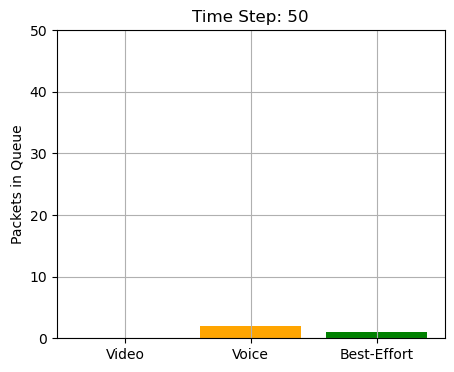

In [91]:
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

for _ in range(50):
    action = env.action_space.sample()  # Random policy
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.2)


In [92]:
env.get_statistics()

{'queue_lengths': [0, 2, 1],
 'arrivals': [11, 8, 13],
 'served': [11, 6, 12],
 'mean_delays': [1.1818181818181819, 4.666666666666667, 3.4166666666666665],
 'qos_violations': [0, 3],
 'violation_rates': [0.0, 0.5],
 'empty_queue_penalty_count': 21}

## 3. Baseline Policies

We’ll now compare three fixed schedulers under the same traffic:
1. **FIFO** – serve the oldest arrival  
2. **EDF** – serve the packet with minimum (deadline – current_wait). i.e. closest to QoS breach  
3. **Sequential Priority** – always serve the highest-priority non-empty queue

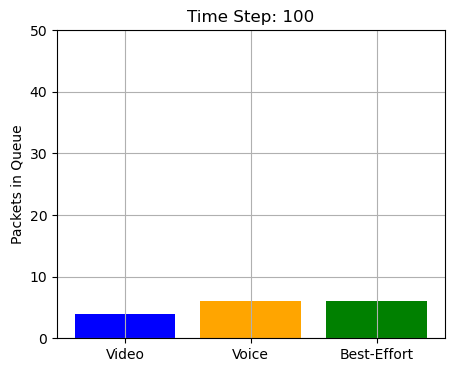

FIFO policy results: {'queue_lengths': [4, 6, 6], 'arrivals': [29, 32, 48], 'served': [25, 26, 42], 'mean_delays': [4.8, 5.423076923076923, 5.476190476190476], 'qos_violations': [8, 17], 'violation_rates': [0.32, 0.6538461538461539], 'empty_queue_penalty_count': 7}


In [93]:
# ─────────────────────────────────────────────────────────────────────────────
# Always serve the packet that arrived earliest
# ─────────────────────────────────────────────────────────────────────────────

# 1. Instantiate & reset
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

# 2. Run for T steps under FIFO
T = 100
for t in range(T):
    # Look at the head‐of‐line arrival time in each queue (or ∞ if empty)
    arrival_times = [
        q[0] if len(q) > 0 else float('inf')
        for q in env.queues
    ]
    # Pick the queue whose first packet arrived earliest
    action = int(np.argmin(arrival_times))
    
    # Step the environment
    obs, reward, done, truncated, info = env.step(action)
    
    # (Optional) visualize queue lengths live
    env.draw_network_queue()
    time.sleep(0.1)

# 3. Gather & print post‐run statistics
stats = env.get_statistics()
print("FIFO policy results:", stats)

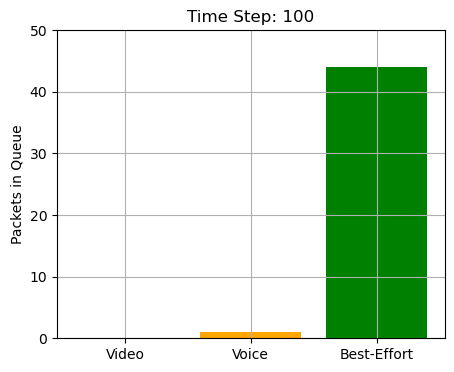

Slack‐aware policy results: {'queue_lengths': [0, 1, 44], 'arrivals': [35, 27, 44], 'served': [35, 26, 0], 'mean_delays': [0.6285714285714286, 1.0, None], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 39}


In [94]:
# ─────────────────────────────────────────────────────────────────────────────
# always serve the packet whose (qos_limit – accumulated_delay) is smallest
# ─────────────────────────────────────────────────────────────────────────────

# 1) instantiate & reset
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

# 2) pull out the per‐queue QoS limits (mean‐delay requirements)
mean_reqs = env.qos_limits    # e.g. [6, 4, None]

# 3) run for T steps
T = 100
for t in range(T):
    slacks = []
    for i, q in enumerate(env.queues):
        # if queue is non‐empty and has a finite QoS limit
        if q and (mean_reqs[i] is not None):
            arrival_time = q[0]                   # packets stored as simple arrival_time
            acc_delay    = env.time - arrival_time  # or t – arrival_time, both track sim time
            slack        = mean_reqs[i] - acc_delay
        else:
            # empty queue or no deadline ⇒ never highest priority
            slack = float('inf')
        slacks.append(slack)

    # choose the queue with minimum slack
    action = int(np.argmin(slacks))

    # step the env 
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)

# 4) final statistics
stats = env.get_statistics()
print("Slack‐aware policy results:", stats)

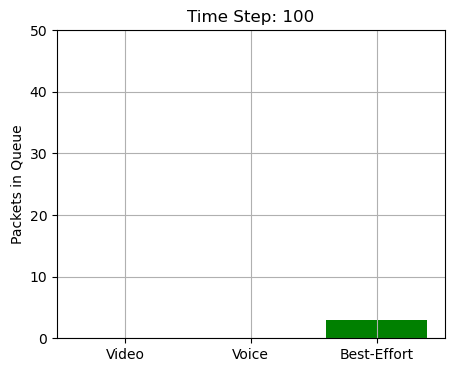

Priority‐policy results: {'queue_lengths': [0, 0, 3], 'arrivals': [29, 20, 48], 'served': [29, 20, 45], 'mean_delays': [0.896551724137931, 1.7, 4.4], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 6}


In [95]:
# ─────────────────────────────────────────────────────────────────────────────
# always serve the highest‐priority non‐empty queue
# ─────────────────────────────────────────────────────────────────────────────

# 1) instantiate & reset
SEED = 42
env = PacketSchedulerEnv(scenario=1, seed=SEED)
obs, _ = env.reset()
SEED = 42
# 2) run for T steps
T = 100
for t in range(T):
    # pick the highest‐priority non‐empty queue
    action = None
    for q_idx in range(env.num_queues):
        if env.queues[q_idx]:
            action = q_idx
            break
    # if all queues empty, default to queue 0 (no service will happen)
    if action is None:
        action = 0

    # step & visualize
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)

# 3) report statistics
stats = env.get_statistics()
print("Priority‐policy results:", stats)

## 5. Tabular Q-Learning Agent

We’ll train a tabular Q-learning agent using scenario 1:
- **State**: discretized queue lengths  
- **Action space**: 3 choices (switch queue, serve queue, do nothing)
- **Hyperparameters**:  
  - α=0.1, γ=0.99  
  - ε-greedy exploration (ε₀=1.0 → εₘᵢₙ=0.01)  
  - Episodes=500, max_steps=100  

In [96]:
# ─────────────────────────────────────────────────────────────────────────────
# Tabular Q-Learning for PacketSchedulerEnv (scenario 1)
# ─────────────────────────────────────────────────────────────────────────────
SEED = 42

# 1) Create the environment
env = PacketSchedulerEnv(scenario=1, seed = SEED)

# 2) Q-table: maps state (tuple) → array of action-values
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# 3) Hyperparameters
alpha         = 0.5    # learning rate
gamma         = 0.99   # discount factor
epsilon       = 1.0    # initial exploration rate
epsilon_min   = 0.5   # minimum ε
epsilon_decay = 0.9  # multiplicative decay per episode
num_episodes  = 2000
max_steps     = 150    # max steps per episode

# 4) Training loop
for ep in range(1, num_episodes+1):
    obs, _ = env.reset(seed=SEED + ep)
    state = tuple(obs)            # cast observation to immutable
    total_reward = 0.0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        # take action
        obs2, reward, done, truncated, info = env.step(action)
        next_state = tuple(obs2)
        total_reward += reward

        # Q-learning update
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        Q[state][action] += alpha * (td_target - Q[state][action])

        state = next_state
        if done or truncated:
            break

    # decay ε
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    stats = env.get_statistics()
    if ep % 100 == 0:
        print(f"Episode {ep}/{num_episodes}  total_reward={total_reward:.1f}  ε={epsilon:.3f}")



Episode 100/2000  total_reward=3.5  ε=0.500
Episode 200/2000  total_reward=1.2  ε=0.500
Episode 300/2000  total_reward=-158.1  ε=0.500
Episode 400/2000  total_reward=-3.7  ε=0.500
Episode 500/2000  total_reward=-2.8  ε=0.500
Episode 600/2000  total_reward=8.0  ε=0.500
Episode 700/2000  total_reward=200.9  ε=0.500
Episode 800/2000  total_reward=55.0  ε=0.500
Episode 900/2000  total_reward=58.2  ε=0.500
Episode 1000/2000  total_reward=10.0  ε=0.500
Episode 1100/2000  total_reward=1.5  ε=0.500
Episode 1200/2000  total_reward=-259.6  ε=0.500
Episode 1300/2000  total_reward=0.8  ε=0.500
Episode 1400/2000  total_reward=1.0  ε=0.500
Episode 1500/2000  total_reward=2.0  ε=0.500
Episode 1600/2000  total_reward=-0.8  ε=0.500
Episode 1700/2000  total_reward=1.2  ε=0.500
Episode 1800/2000  total_reward=-10.4  ε=0.500
Episode 1900/2000  total_reward=4.0  ε=0.500
Episode 2000/2000  total_reward=-2.1  ε=0.500


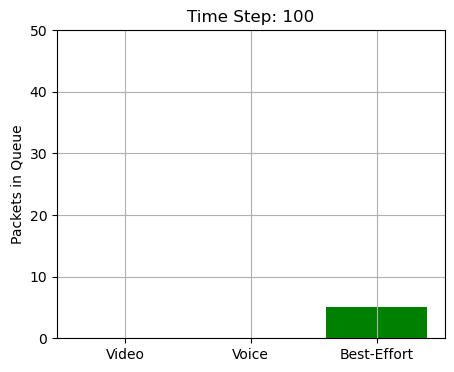

Trained Q-Learning policy results: {'queue_lengths': [0, 0, 5], 'arrivals': [29, 20, 48], 'served': [29, 20, 43], 'mean_delays': [1.103448275862069, 1.5, 6.813953488372093], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 8}


In [97]:
# 5) Evaluate the learned policy
obs, _ = env.reset(seed=SEED)
state = tuple(obs)
for t in range(100):
    action = int(np.argmax(Q[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)
    state = tuple(obs)
    if done or truncated:
        break

print("Trained Q-Learning policy results:", env.get_statistics())

In [98]:
def coarse_bin_length(length, max_size=50):
    if length == 0:
        return 0
    elif length <= max_size * 0.2:
        return 1
    elif length <= max_size * 0.7:
        return 2
    else:
        return 3

def coarse_bin_slack(slack, qos_limit):
    # -2 = expired, -1 = urgent, 0 = approaching, 1 = safe, 2 = plenty
    if slack <= 0:
        return -2
    elif slack < qos_limit * 0.2:
        return -1
    elif slack < qos_limit * 0.5:
        return 0
    elif slack < qos_limit * 0.8:
        return 1
    else:
        return 2

def get_coarse_state(env):
    len0 = coarse_bin_length(len(env.queues[0]), env.max_queue_size)
    len1 = coarse_bin_length(len(env.queues[1]), env.max_queue_size)
    len2 = coarse_bin_length(len(env.queues[2]), env.max_queue_size)
    slack0 = env.qos_limits[0] - (env.time - env.queues[0][0]) if env.queues[0] else env.qos_limits[0]
    slack1 = env.qos_limits[1] - (env.time - env.queues[1][0]) if env.queues[1] else env.qos_limits[1]
    slack_bin0 = coarse_bin_slack(slack0, env.qos_limits[0])
    slack_bin1 = coarse_bin_slack(slack1, env.qos_limits[1])
    return (env.current_queue, len0, len1, len2, slack_bin0, slack_bin1)

In [99]:
# ─────────────────────────────────────────────────────────────────────────────
# Tabular Q-Learning for PacketSchedulerEnv (scenario 2)
# ─────────────────────────────────────────────────────────────────────────────
SEED = 42

env = PacketSchedulerEnv(scenario=2, seed=SEED)
Q = defaultdict(lambda: np.zeros(env.action_space.n))

alpha         = 0.7
gamma         = 0.99
epsilon       = 1.0
epsilon_min   = 0.2
epsilon_decay = 0.9
num_episodes  = 10000
max_steps     = 250

for ep in range(1, num_episodes + 1):
    obs, _ = env.reset(seed=SEED + ep)
    state = get_coarse_state(env)
    total_reward = 0

    for t in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        obs2, reward, done, truncated, _ = env.step(action)
        next_state = get_coarse_state(env)
        total_reward += reward

        # Q-learning update
        best_next = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

        state = next_state
        if done or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if ep % 500 == 0:
        stats = env.get_statistics()
        print(f"Episode {ep}/{num_episodes} | Reward: {total_reward:.2f} | "
              f"Video Violation: {stats['violation_rates'][0]:.2f} | "
              f"Voice Violation: {stats['violation_rates'][1]:.2f} | "
              f"Epsilon: {epsilon:.3f}")


Episode 500/10000 | Reward: -30395.65 | Video Violation: 0.41 | Voice Violation: 1.00 | Epsilon: 0.200
Episode 1000/10000 | Reward: -21632.32 | Video Violation: 1.00 | Voice Violation: 0.67 | Epsilon: 0.200
Episode 1500/10000 | Reward: -29137.90 | Video Violation: 0.92 | Voice Violation: 0.55 | Epsilon: 0.200
Episode 2000/10000 | Reward: -26616.60 | Video Violation: 0.71 | Voice Violation: 0.90 | Epsilon: 0.200
Episode 2500/10000 | Reward: -31348.85 | Video Violation: 0.93 | Voice Violation: 1.00 | Epsilon: 0.200
Episode 3000/10000 | Reward: 3.00 | Video Violation: 0.00 | Voice Violation: 0.00 | Epsilon: 0.200
Episode 3500/10000 | Reward: -29380.60 | Video Violation: 1.00 | Voice Violation: 1.00 | Epsilon: 0.200
Episode 4000/10000 | Reward: -32029.15 | Video Violation: 0.23 | Voice Violation: 1.00 | Epsilon: 0.200
Episode 4500/10000 | Reward: -26578.60 | Video Violation: 0.59 | Voice Violation: 1.00 | Epsilon: 0.200
Episode 5000/10000 | Reward: -26187.70 | Video Violation: 0.83 | Voice

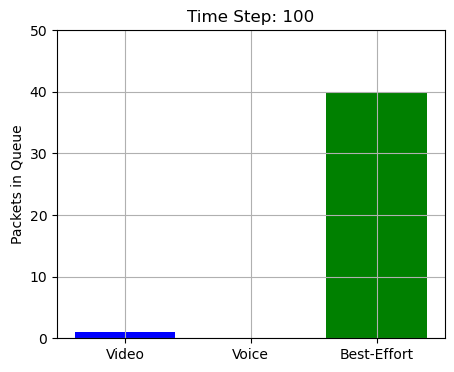

Trained Q-Learning policy results scenario 2 binned:
 {'queue_lengths': [1, 0, 40], 'arrivals': [29, 20, 48], 'served': [28, 20, 8], 'mean_delays': [3.4285714285714284, 7.25, 28.875], 'qos_violations': [1, 9], 'violation_rates': [0.03571428571428571, 0.45], 'empty_queue_penalty_count': 2}


In [100]:
# Evaluation
obs, _ = env.reset(seed=SEED)
state = get_coarse_state(env)
for t in range(100):
    action = int(np.argmax(Q[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()  # Optional: visualize
    state = get_coarse_state(env)
    if done or truncated:
        break
print("Trained Q-Learning policy results scenario 2 binned:\n", env.get_statistics())

In [101]:
print("Trained Q-Learning policy results scenario 2\n:", env.get_statistics())

Trained Q-Learning policy results scenario 2
: {'queue_lengths': [1, 0, 40], 'arrivals': [29, 20, 48], 'served': [28, 20, 8], 'mean_delays': [3.4285714285714284, 7.25, 28.875], 'qos_violations': [1, 9], 'violation_rates': [0.03571428571428571, 0.45], 'empty_queue_penalty_count': 2}


In [ ]:
# # Plot total rewards per episode
# plt.figure(figsize=(12, 4))
# plt.plot(episode_rewards, label='Total Reward')
# plt.title('Q-learning: Episode Reward Over Time (Scenario 2)')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot violation rates
# plt.figure(figsize=(12, 4))
# plt.plot(violation_rates_video, label='Video QoS Violation Rate')
# plt.plot(violation_rates_voice, label='Voice QoS Violation Rate')
# plt.title('QoS Violation Rate per Episode')
# plt.xlabel('Episode')
# plt.ylabel('Violation Rate')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot empty serve counts
# plt.figure(figsize=(12, 4))
# plt.plot(empty_serve_counts, label='Empty Queue Serve Count', color='red')
# plt.title('Empty Queue Serves Over Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Count')
# plt.grid(True)
# plt.legend()
# plt.show()
